# Familiarisation avec les données

## Deux types de données
 
**Raster**:

* utilise une matrice de zones carrées, des pixels, dont la taille détermine le détail qui peut être conservé dans le jeu de données
* la valeur d'un pixel peut être continue (ex: altitude) ou catégorielle (ex: utilisation des terres)
* décrit l'intérieur des entitiés cartographiques
* utile pour capturer, stocker et analyser des données qui varient continuellement d'un endroit à l'autre (altitude, température, pH du sol, etc.)

**Vector**:

* utilise des coordonnées _x_ et _y_ pour définir la forme et l'emplacement des zones correspondant aux entités cartographiques
* un vecteur peut être un point (ex: point d'intérêt), une ligne (ex: route) ou un polygone (ex: lac)
* décrit le centre et les bords des entités
* utile pour capturer et stocker des détails spatiaux

https://mapasyst.extension.org/what-is-the-difference-between-raster-and-vector-data/#:~:text=Vector%20data%20are%20excellent%20for,store%20aerial%20and%20satellite%20imagery.

https://carpentries-incubator.github.io/geospatial-python/aio/index.html

## De quelles informations disposons-nous ?

Voir _V. Product description_ du manuel d'utilisation, en particulier _V.I.II. Nomenclature_ et _V.II. CLC status layer products_.

## Exploration des données

In [65]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import shapely
import pandas as pd
from shapely.geometry import mapping
import rioxarray as rxr
import fiona

### Vector

In [66]:
# clc = gpd.read_file("data/u2018_clc2018_v2020_20u1_geoPackage/DATA/U2018_CLC2018_V2020_20u1.gpkg")

Impossible de lire tout le fichier _.gpkg_ d'un coup car le programme plante. J'en extrais donc des zones manuellement à l'aide de `QGIS`.


In [67]:
zones = fiona.listlayers("data/zones/zones.gpkg")
zones

['zone-21',
 'zone-22',
 'zone-31',
 'zone-32',
 'zone-12',
 'zone-13',
 'zone-41',
 'zone-51',
 'zone-52',
 'zone-61',
 'zones-71',
 'zone-11']

In [68]:
zone_11_gdf = gpd.read_file("data/zones/zones.gpkg", layer="zone-11")
zone_11_gdf.head()

,OBJECTID,Code_18,Remark,Area_Ha,ID,geometry
0,458367,111,None,32.684892,EU_458367,"MULTIPOLYGON (((3764057.100 2879442.440, 37638..."
1,464474,112,None,674.856306,EU_464474,"MULTIPOLYGON (((3772518.090 2869459.160, 37724..."
2,464486,112,None,125.582284,EU_464486,"MULTIPOLYGON (((3751235.850 2867880.030, 37509..."
3,464494,112,None,44.825253,EU_464494,"MULTIPOLYGON (((3753121.110 2869761.200, 37531..."
4,464503,112,None,30.711344,EU_464503,"MULTIPOLYGON (((3749222.430 2870367.950, 37491..."


In [69]:
zone_11_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 692 entries, 0 to 691
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   OBJECTID  692 non-null    int64   
 1   Code_18   692 non-null    object  
 2   Remark    0 non-null      object  
 3   Area_Ha   692 non-null    float64 
 4   ID        692 non-null    object  
 5   geometry  692 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(3)
memory usage: 32.6+ KB


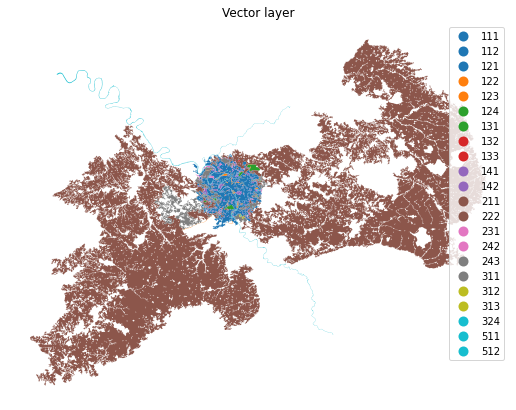

In [453]:
f, ax = plt.subplots(figsize=(14,7))
zone_11_gdf.plot(column="Code_18", legend=True, ax=ax)
plt.title("Vector layer")
ax.set_axis_off()
plt.show()

#### Codes

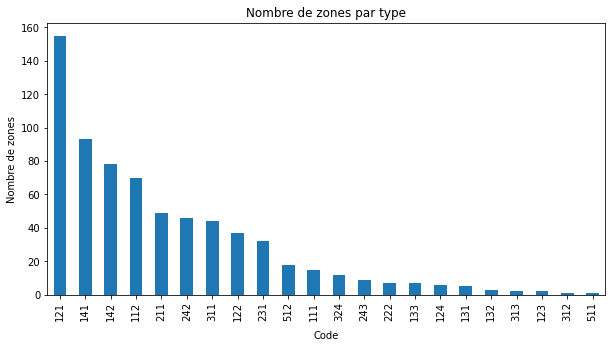

In [71]:
zone_11_gdf.Code_18.value_counts().plot(kind="bar", figsize=(10, 5))
plt.xlabel("Code",  labelpad=10)
plt.ylabel("Nombre de zones")
plt.title("Nombre de zones par type");

In [72]:
# nodata
zone_11_gdf[zone_11_gdf.Code_18 == "999"]

,OBJECTID,Code_18,Remark,Area_Ha,ID,geometry


#### Area

In [73]:
zone_11_gdf.Area_Ha.describe()

count    6.920000e+02
mean     3.730443e+03
std      6.120669e+04
min      2.502368e+01
25%      3.299732e+01
50%      5.519455e+01
75%      1.256282e+02
max      1.140250e+06
Name: Area_Ha, dtype: float64

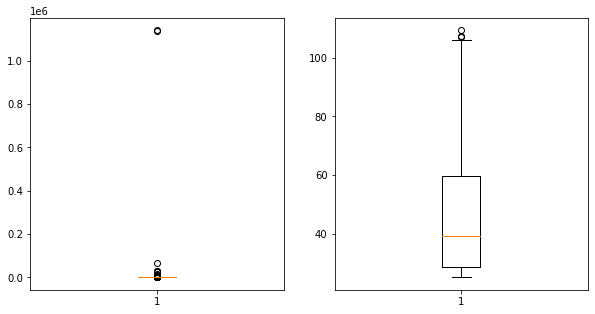

In [74]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.boxplot(zone_11_gdf.Area_Ha)
plt.subplot(122)
plt.boxplot(zone_11_gdf.Area_Ha[zone_11_gdf.Area_Ha < 110])
plt.show()

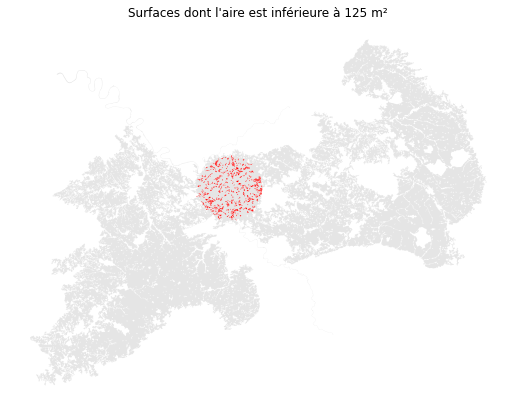

In [392]:
zone_11_gdf_area_low = zone_11_gdf[zone_11_gdf.Area_Ha < 125]
zone_11_gdf_area_high = zone_11_gdf[zone_11_gdf.Area_Ha >= 125]

f, ax = plt.subplots(figsize=(14, 7))
zone_11_gdf_area_high.plot(ax=ax, color="black", alpha = 0.1)
zone_11_gdf_area_low.plot(ax=ax, color = "red")
ax.set_axis_off()
plt.title("Surfaces dont l'aire est inférieure à 125 m²")
plt.show()

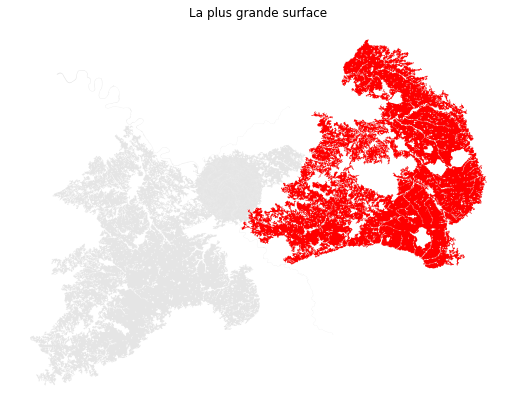

In [454]:
f, ax = plt.subplots(figsize=(14, 7))
zone_11_gdf.plot(ax=ax, color = "black", alpha = 0.1)
zone_11_gdf[zone_11_gdf.Area_Ha == max(zone_11_gdf.Area_Ha)].plot(ax=ax, color = "red")
ax.set_axis_off()
plt.title("La plus grande surface")
plt.show()

#### Voisins distants et superposés

Vérifions que les surfaces voisines se touchent et ne se superposent pas.

In [ ]:
distanced_dict = {"zone": [], "src": [], "dest": [], "distance": []}
overlapped_dict = {"zone": [], "src": [], "dest": []}

for zone in zones:
    gdf = gpd.read_file("data/zones/zones.gpkg", layer=zone)
    print(f"{zone} ({gdf.shape[0]} instances)", end=" ")

    for index, area in gdf.iterrows():
        distances = gdf.geometry.distance(area.geometry)

        neighbors_d = gdf[(distances < 10) & (distances != 0) & (gdf.OBJECTID != area.OBJECTID)]
        zone_d = [zone] * neighbors_d.shape[0]
        src_d = [area.OBJECTID] * neighbors_d.shape[0]
        dest_d = neighbors_d.OBJECTID.tolist()
        d = distances[neighbors_d.index].tolist()

        distanced_dict["zone"].extend(zone_d)
        distanced_dict["src"].extend(src_d)
        distanced_dict["dest"].extend(dest_d)
        distanced_dict["distance"].extend(d)

        neighbors_o = gdf[(distances == 0) & (gdf.OBJECTID != area.OBJECTID)]
        neighbors_o =neighbors_o[neighbors_o.geometry.overlaps(area.geometry)]
        zone_o = [zone] * neighbors_o.shape[0]
        src_o = [area.OBJECTID] * neighbors_o.shape[0]
        dest_o = neighbors_o.OBJECTID.tolist()

        overlapped_dict["zone"].extend(zone_o)
        overlapped_dict["src"].extend(src_o)
        overlapped_dict["dest"].extend(dest_o)

    print("[ok]")

print("finished")

distanced_df = pd.DataFrame(distanced_dict)
overlapped_df = pd.DataFrame(overlapped_dict)

distanced_df.to_csv("data/zones/distanced.csv")
overlapped_df.to_csv("data/zones/overlapped.csv")

In [78]:
overlapped_df = pd.read_csv("data/zones/overlapped.csv")
overlapped_df.head()

,Unnamed: 0,zone,src,dest


Sur l'ensemble des données testées, il n'y a pas de surfaces qui se superposent. On considèrera donc qu'il n'y a pas de surfaces qui se superposent sur la totalité du jeu de données pour la suite.

In [79]:
distanced_df = pd.read_csv("data/zones/distanced.csv")
distanced_df.head()

,Unnamed: 0,zone,src,dest,distance
0,0,zone-21,69098,69110,4.779658
1,0,zone-21,69110,69098,4.779658
2,0,zone-21,73173,75837,1.178111
3,0,zone-21,75806,77407,4.747340
4,0,zone-21,75837,73173,1.178111


Il semble y avoir des couples de voisins légèrement éloignés, mais il faut vérifier qu'ils sont effectivement voisins en vérifiant qu'il n'y a pas un autre terrain entre les deux par exemple.

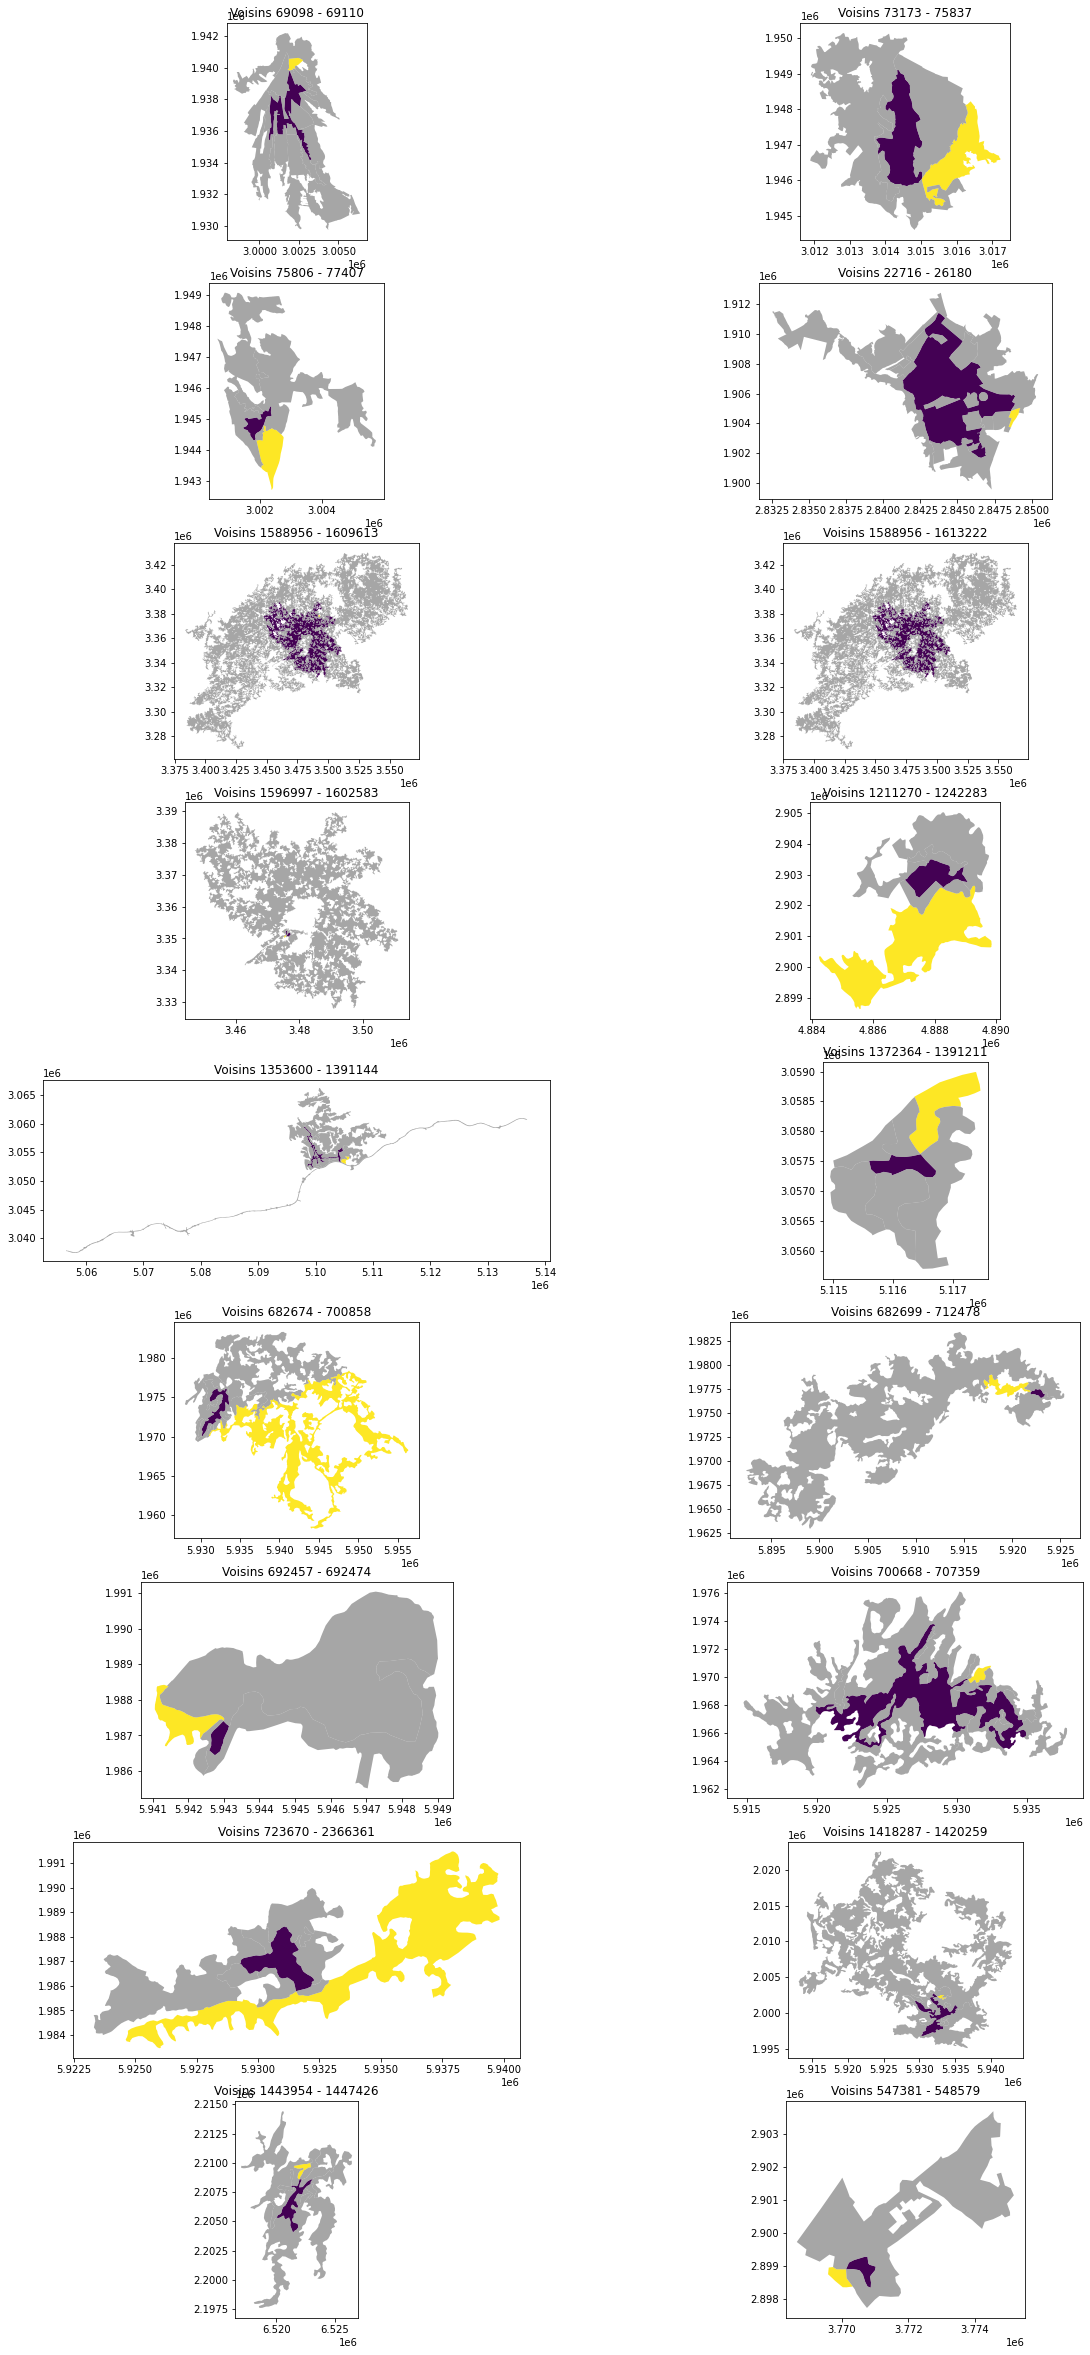

In [391]:
f = plt.figure(figsize=(20, 90))

i = 0
src = []
for index, neighbors in distanced_df.iterrows():
    if neighbors.dest in src:
        continue

    src.append(neighbors.src)

    # add a new subplot iteratively
    ax = plt.subplot(int(distanced_df.shape[0]/2)+1, 2, i + 1)
    i = i+1

    gdf = gpd.read_file("data/zones/zones.gpkg", layer=neighbors.zone)
    areas = gdf[gdf.OBJECTID.isin([neighbors.src, neighbors.dest])]
    areas.plot("OBJECTID", ax=ax)

    other = gdf[gdf.geometry.touches(areas.iloc[0].geometry)]
    if other.shape[0] > 0:
        other.plot(color="grey", ax=ax, alpha=0.7)

    ax.set_title(f"Voisins {neighbors.src} - {neighbors.dest}")

plt.show()

Les surfaces sont à chaque fois séparées par une autre surface. On considèrera donc qu’il n’y a pas de voisins espacés sur la totalité du jeu de données pour la suite.

### Raster

In [81]:
attributes = gpd.read_file("data/clc/u2018_clc2018_v2020_20u1_raster100m/DATA/U2018_CLC2018_V2020_20u1.tif.vat.dbf")
attributes.head()

,Value,Count,LABEL3,Red,Green,Blue,CODE_18,geometry
0,1,800699.0,Continuous urban fabric,0.901961,0.000000,0.301961,111,None
1,2,17085234.0,Discontinuous urban fabric,1.000000,0.000000,0.000000,112,None
2,3,3210212.0,Industrial or commercial units,0.800000,0.301961,0.949020,121,None
3,4,414626.0,Road and rail networks and associated land,0.800000,0.000000,0.000000,122,None
4,5,122685.0,Port areas,0.901961,0.800000,0.800000,123,None


Les données raster contiennent les attributs rouge, vert et bleu mais pas infrarouge.

Geopandas ne gère pas les données raster, il faut un outil pour les exploiter: `rioxarray`.

À l'aide de QGIS, j'ai extrait manuellement une zone de la carte complète qui contient celle du jeu de données vectoriel.

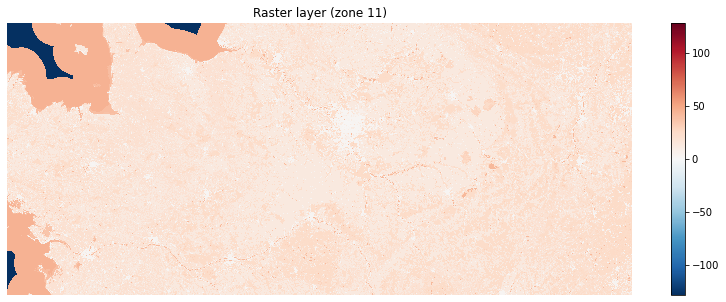

In [413]:
# raster = rxr.open_rasterio('data/zone-11.tif', masked=True).squeeze()
raster = rxr.open_rasterio('data/zones/zone-11.tif').squeeze()

f, ax = plt.subplots(figsize=(14, 5))
raster.plot.imshow(ax=ax)
ax.set(title="Raster layer (zone 11)")
ax.set_axis_off()
plt.show()

**Interrogation**: à quoi servent les autres données (`U2018_CLC2018_V2020_20u1.tif.ovr`, `U2018_CLC2018_V2020_20u1.tfw`...) ?

### Association vector - raster

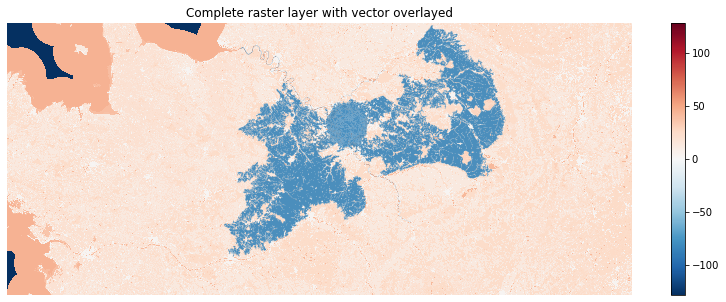

In [445]:
f, ax = plt.subplots(figsize=(14, 5))
zone_11_gdf.plot(ax=ax, alpha=.8)
raster.plot.imshow(ax=ax)
ax.set(title="Complete raster layer with vector overlayed")
ax.set_axis_off()
plt.show()

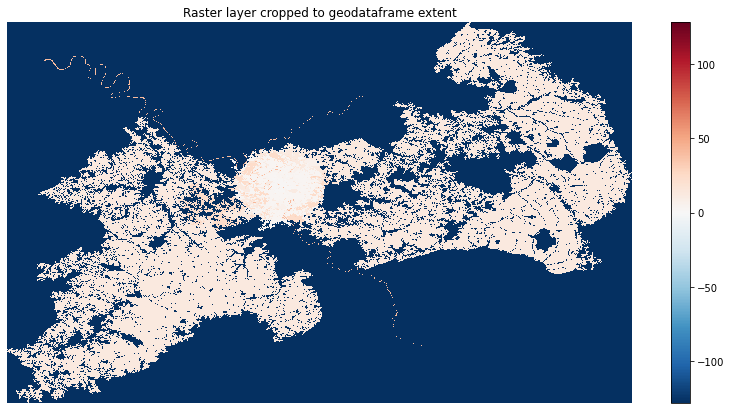

In [421]:
raster_clipped = raster.rio.clip(zone_11_gdf.geometry.apply(mapping),
                                 # This is needed if your zone_11_gdf is in a diff CRS than the raster data
                                 zone_11_gdf.crs)

f, ax = plt.subplots(figsize=(14, 7))
raster_clipped.plot(ax=ax)
ax.set(title="Raster layer cropped to geodataframe extent")
ax.set_axis_off()
plt.show()

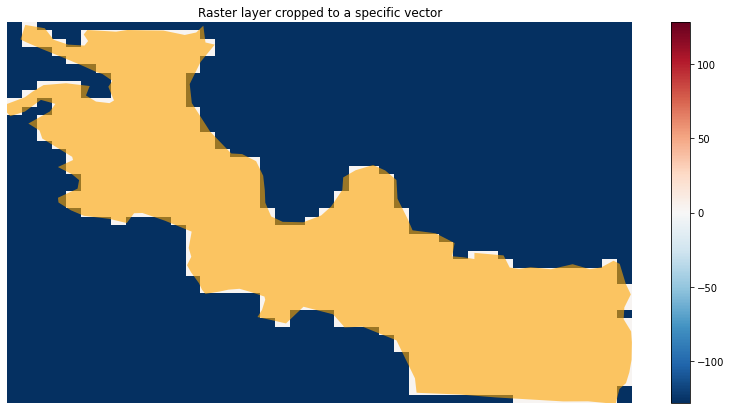

In [447]:
test = raster.rio.clip(zone_11_gdf.geometry[1].geoms)

f, ax = plt.subplots(figsize=(14, 7))
zone_11_gdf.loc[[1], 'geometry'].plot(ax=ax, color="orange", alpha=.6)
test.plot.imshow(ax=ax)
ax.set(title="Raster layer cropped to a specific vector")
ax.set_axis_off()
plt.show()

Les données raster n'ont finalement pas l'air d'ếtre intéressantes à exploiter car on ne dispose pas de données RGB propres à chaque pixel. En effet, il semble que l'on dispose uniquement de valeurs RGB associées de manière générale aux codes CLC.

## Prélèvement automatique de zones géographiques

L'extraction manuelle des zones à l'aide de QGIS est trop fastidieuse, il faut un moyen d'automatiser le processus. En plus, cette méthode n'est pas précise. Geopandas donne la possibilité de charger uniquement une partie du jeu de données complet en fonction de coordonnées données. C'est ce que nous allons utiliser.

Le module GeoPy, intégré au sein de Geopandas, permet de convertir un nom en coordonnées géographiques. À partir de ce point, nous pouvons créer une zone avec un certain rayon et extraire la partie du jeu de données complet qui lui correspond.

Des sites comme http://www.geonames.org/ permettent aussi de récupérer des coordonnées géographiques à partir d'un nom


In [86]:
paris_location = gpd.tools.geocode("Paris")
paris_location

,geometry,address
0,POINT (2.32004 48.85889),"Paris, 75000;75001;75002;75003;75004;75005;750..."


In [87]:
paris_area = paris_location.geometry.buffer(10)

/tmp/ipykernel_16181/1448691870.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  paris_area = paris_location.geometry.buffer(10)


In [88]:
paris_location.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [89]:
zone_11_gdf.crs

<Derived Projected CRS: EPSG:3035>
Name: ETRS89-extended / LAEA Europe
Axis Info [cartesian]:
- Y[north]: Northing (metre)
- X[east]: Easting (metre)
Area of Use:
- name: Europe - European Union (EU) countries and candidates. Europe - onshore and offshore: Albania; Andorra; Austria; Belgium; Bosnia and Herzegovina; Bulgaria; Croatia; Cyprus; Czechia; Denmark; Estonia; Faroe Islands; Finland; France; Germany; Gibraltar; Greece; Hungary; Iceland; Ireland; Italy; Kosovo; Latvia; Liechtenstein; Lithuania; Luxembourg; Malta; Monaco; Montenegro; Netherlands; North Macedonia; Norway including Svalbard and Jan Mayen; Poland; Portugal including Madeira and Azores; Romania; San Marino; Serbia; Slovakia; Slovenia; Spain including Canary Islands; Sweden; Switzerland; Turkey; United Kingdom (UK) including Channel Islands and Isle of Man; Vatican City State.
- bounds: (-35.58, 24.6, 44.83, 84.73)
Coordinate Operation:
- name: Europe Equal Area 2001
- method: Lambert Azimuthal Equal Area
Datum: Europ

In [90]:
paris_location_projected = paris_location.to_crs(epsg=3035)

In [160]:
paris_area = paris_location_projected.geometry.buffer(40000)
paris_area

0    POLYGON ((3798451.870 2889983.454, 3798259.259...
dtype: geometry

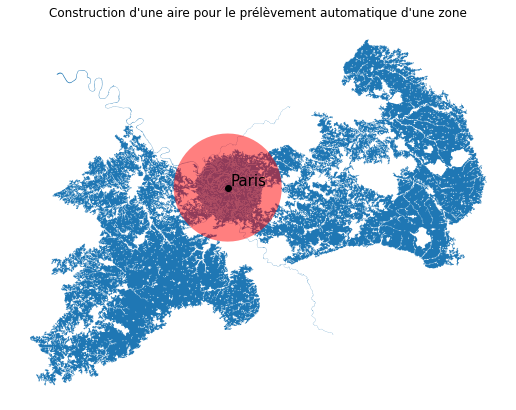

In [448]:
f,ax = plt.subplots(figsize=(14,7))
zone_11_gdf.plot(ax=ax)
paris_area.plot(ax=ax, color="red", alpha=0.5)
center = paris_area.geometry.centroid
center.plot(ax=ax, color="black", label="Paris")
plt.annotate("Paris", xy=(center.x, center.y), xytext=(center.x + 2000, center.y + 2000), color="black", fontsize = 15)
plt.title("Construction d'une aire pour le prélèvement automatique d'une zone")
ax.set_axis_off()
plt.show()

Remarque : puisque les capitales ne sont pas de même taille, on prendra des petites zones pour augmenter les chances de ne pas prendre des terrains non urbains.

On a réussi à créer une zone à partir d'un nom de ville, on peut maintenant extraire les données correspondantes à partir du jeu de données complet

In [167]:
paris_gdf = gpd.read_file("data/clc/u2018_clc2018_v2020_20u1_geoPackage/DATA/U2018_CLC2018_V2020_20u1.gpkg", mask=paris_area)

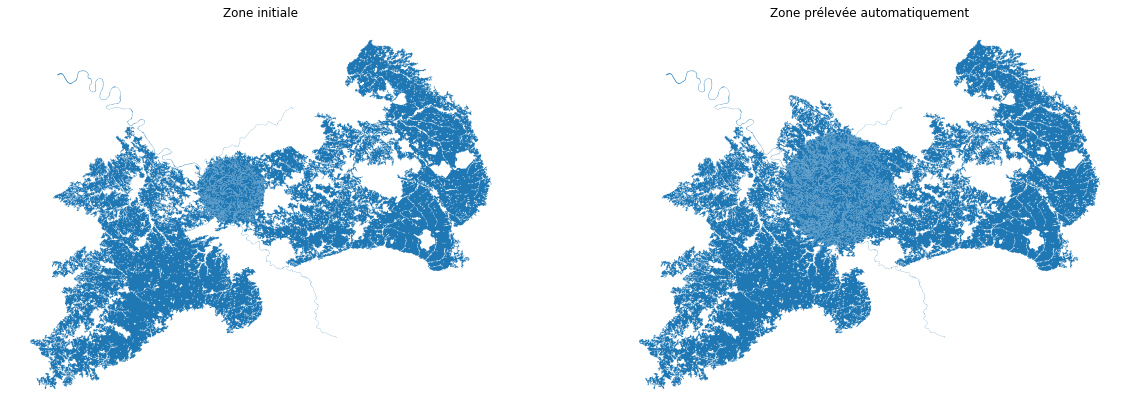

In [449]:
plt.figure(figsize=(20,10))
ax = plt.subplot(121)
zone_11_gdf.plot(ax=ax)
ax.set_axis_off()
plt.title("Zone initiale")
ax = plt.subplot(122)
paris_gdf.plot(ax=ax)
plt.title("Zone prélevée automatiquement")
ax.set_axis_off()
plt.show()

On retrouve bien la même région de la carte que celle extraite manuellement.

In [165]:
def location_to_gdf(location, radius=3000, data_path="data/clc/u2018_clc2018_v2020_20u1_geoPackage/DATA/U2018_CLC2018_V2020_20u1.gpkg"):
    location_coords = gpd.tools.geocode(location).to_crs(epsg=3035)
    area = location_coords.geometry.buffer(radius)
    gdf = gpd.read_file(data_path, mask=area)
    return gdf

## Vérification des longueurs

Vérifions les longueurs calculées par geopandas sur une zone dont on connait les dimensions. Par exemple, le lac d'Annecy:

* Périmètre : 38 km
* Aire :  26.5 km²

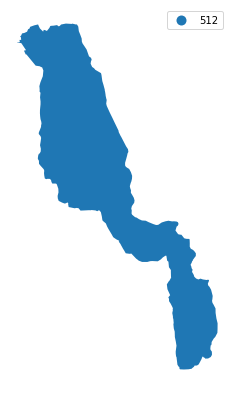

In [450]:
f, ax = plt.subplots(figsize=(14,7))
gdf = location_to_gdf("Lac d'Annecy", 100)
gdf.plot("Code_18", legend=True, ax=ax)
ax.set_axis_off()
plt.show()

In [97]:
lac_annecy = gdf.iloc[0]
code = lac_annecy.Code_18
label = attributes[attributes.CODE_18 == code].iloc[0].LABEL3
print(f"{code} - {label}")

512 - Water bodies


In [98]:
print("Aire attendue: 26.5 km²")
print(f"Aire calculée: {round(lac_annecy.geometry.area/1e6, 1)} km²")

Aire attendue: 26.5 km²
Aire calculée: 26.7 km²


In [99]:
print("Périmètre attendu: 38.0 km")
print(f"Périmètre calculé: {round(lac_annecy.geometry.length/1e3, 1)} km")

Périmètre attendu: 38.0 km
Périmètre calculé: 37.0 km


Les longueurs calculées correspondent aux longueurs attendues. On pourra donc s'en servir pour l'apprentissage.

# Classification de graphes

In [100]:
import dgl
from dgl.data import DGLDataset
import torch
import networkx as nx
import matplotlib.image as mpimg
import os

## Construction du jeu de données

### Capitales

In [101]:
countries = ["Allemagne", "Espagne", "Finlande", "France", "Italie", "Pologne", "Roumanie", "Royaume-Uni", "Suède"]
capitals = ["Berlin", "Madrid", "Helsinki", "Paris", "Rome", "Varsovie", "Bucarest", "Londres", "Stockholm"]

J'ai récupéré des grandes capitales de taille similaire. Les villes plus petites sont composées de peu de polygones et forcent à réduire la taille d'extraction des zones.

#### Choix de la taille des zones

L'objectif est de récupérer des zones qui représentent au mieux les espaces urbains. On ne veut donc pas inclure de parcelles représentant des zones rurales. Il faut donc choisir une taille de zone assez grande pour avoir un nombre d'instances suffisant pour l'apprentissage, mais pas trop grande pour ne pas récupérer la périphérie des plus petites villes.

In [102]:
legend = pd.read_csv("data/clc/u2018_clc2018_v2020_20u1_geoPackage/Legend/clc_legend.csv")
legend.head()

,GRID_CODE,CLC_CODE,LABEL1,LABEL2,LABEL3,RGB
0,1,111,Artificial surfaces,Urban fabric,Continuous urban fabric,230-000-077
1,2,112,Artificial surfaces,Urban fabric,Discontinuous urban fabric,255-000-000
2,3,121,Artificial surfaces,"Industrial, commercial and transport units",Industrial or commercial units,204-077-242
3,4,122,Artificial surfaces,"Industrial, commercial and transport units",Road and rail networks and associated land,204-000-000
4,5,123,Artificial surfaces,"Industrial, commercial and transport units",Port areas,230-204-204


In [103]:
labels = legend.LABEL1.unique().tolist()
labels

['Artificial surfaces',
 'Agricultural areas',
 'Forest and semi natural areas',
 'Wetlands',
 'Water bodies',
 'NODATA',
 'UNCLASSIFIED']

In [104]:
def calc_category_counts(gdf, labels):
    counts = gdf.Code_18.str[0].value_counts(ascending=True)
    counts.index = list(map(lambda i: labels[int(i) - 1], counts.index.tolist()))
    return counts

https://stackoverflow.com/questions/13784192/creating-an-empty-pandas-dataframe-then-filling-it

In [112]:
def test_extraction_radius(locations, radius, labels, plot=True, fun=location_to_gdf):
    category_counts_dict = {category: np.zeros(len(locations), dtype=np.int64) for category in labels}
    total_counts_dict = {category: np.zeros(len(radius)) for category in ["instances"] + labels}

    if plot is True:
        plt.figure(figsize=(20,15))

    for j in range(len(radius)):
        for i in range(len(locations)):
            gdf = fun(locations[i], radius=radius[j])
            counts = calc_category_counts(gdf, labels)
            for category, count in counts.iteritems():
                category_counts_dict[category][i] = count

        category_counts_df = pd.DataFrame(category_counts_dict, index=locations)

        if plot is True:
            if j > 0 and j%6 == 0:
                plt.show()
                plt.figure(figsize=(20,15))

            ax = plt.subplot(3, 2, (j%6)+1)
            category_counts_df.plot.barh(ax = ax, stacked=True)
            plt.legend(loc='lower left')
            plt.title(f"Répartition des parcelles pour R = {radius[j]}")

        nb_instances = category_counts_df.values.sum()

        total_counts_dict["instances"][j] = nb_instances

        for category, total_count in category_counts_df.sum().iteritems():
            total_counts_dict[category][j] = round(total_count/nb_instances,2)

    if plot is True:
        plt.show()

    total_counts_df = pd.DataFrame(total_counts_dict, index=radius)
    total_counts_df.instances = total_counts_df.instances.astype(int)

    return total_counts_df

In [106]:
capitals_location = [f"{capitals[i]}, {countries[i]}" for i in range(len(capitals))]
capitals_location

['Berlin, Allemagne',
 'Madrid, Espagne',
 'Helsinki, Finlande',
 'Paris, France',
 'Rome, Italie',
 'Varsovie, Pologne',
 'Bucarest, Roumanie',
 'Londres, Royaume-Uni',
 'Stockholm, Suède']

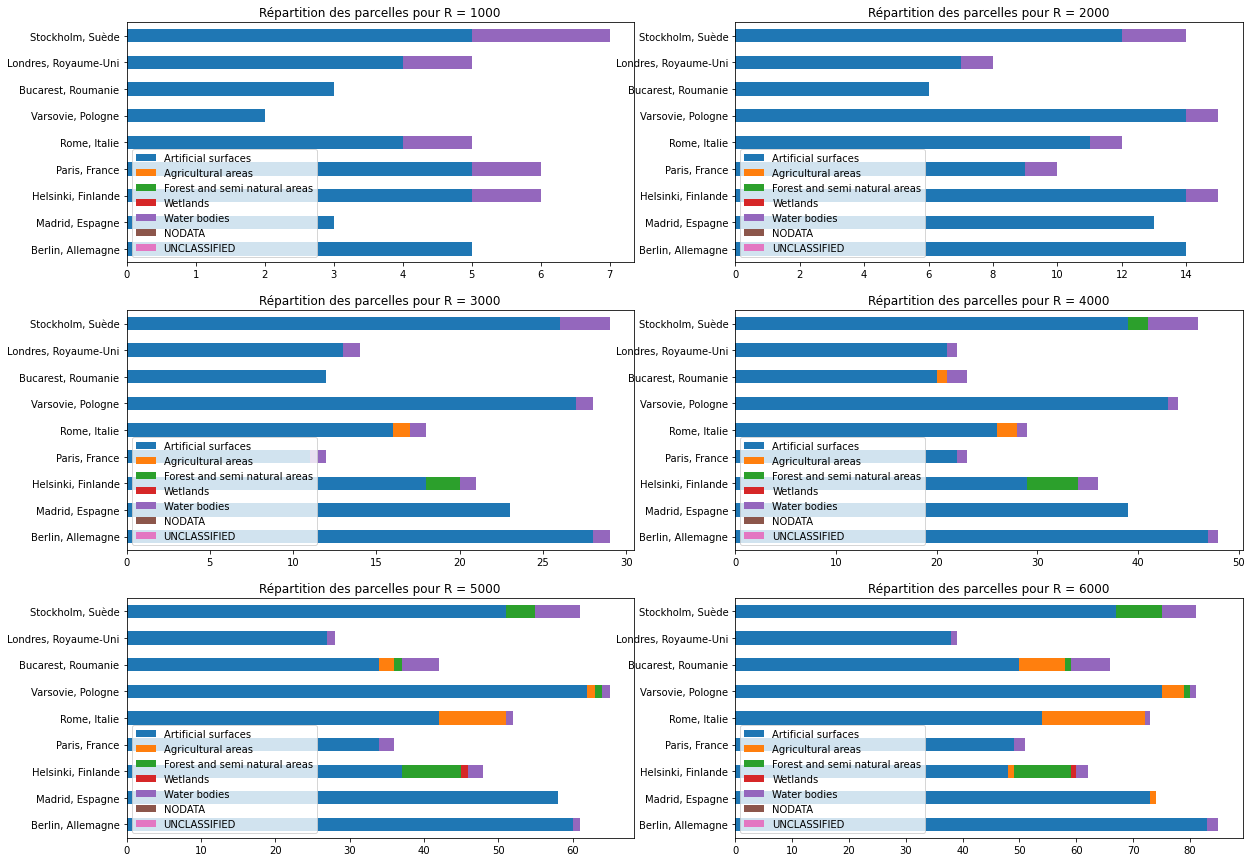

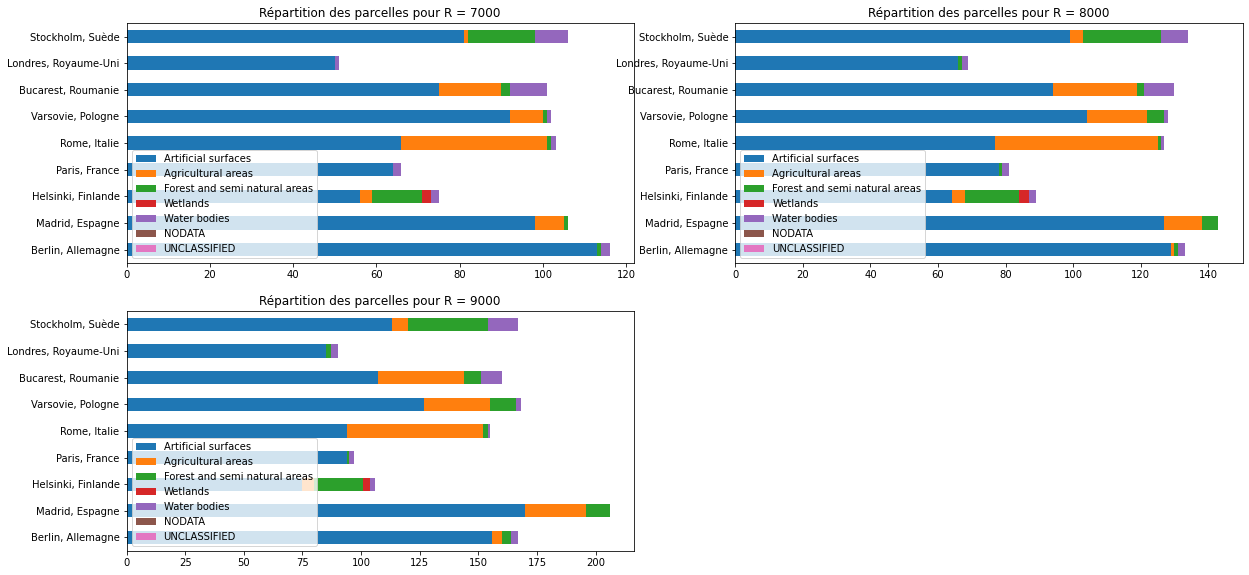

,instances,Artificial surfaces,Agricultural areas,Forest and semi natural areas,Wetlands,Water bodies,NODATA,UNCLASSIFIED
1000,42,0.86,0.00,0.00,0.0,0.14,0.0,0.0
2000,107,0.93,0.00,0.00,0.0,0.07,0.0,0.0
3000,186,0.94,0.01,0.01,0.0,0.05,0.0,0.0
4000,310,0.92,0.01,0.02,0.0,0.05,0.0,0.0
5000,451,0.90,0.03,0.03,0.0,0.04,0.0,0.0
6000,612,0.88,0.05,0.03,0.0,0.04,0.0,0.0
7000,826,0.84,0.08,0.04,0.0,0.03,0.0,0.0
8000,1034,0.81,0.11,0.05,0.0,0.03,0.0,0.0
9000,1316,0.78,0.13,0.07,0.0,0.03,0.0,0.0


In [107]:
total_counts_df = test_extraction_radius(capitals_location, range(1000, 10000, 1000), labels)
total_counts_df

Nous pourrons prendre un rayon entre 3000 et 5000 mètres pour maximiser le taux de parcelles urbaines dans le jeu de données tout en conservant un nombre important d'instances. Il sera peut-être nécessaire, en fonction des résultats de l'apprentissage, d'augmenter ce rayon ou d'utiliser plus de villes pour avoir plus d'instances.

### Campagnes

In [113]:
def coords_to_gdf(xy, radius=5000, data_path="data/clc/u2018_clc2018_v2020_20u1_geoPackage/DATA/U2018_CLC2018_V2020_20u1.gpkg"):
    area = shapely.geometry.Point(xy[0], xy[1]).buffer(radius)
    gdf = gpd.read_file(data_path, mask=area)
    return gdf

In [114]:
campaigns_coords = pd.read_csv("data/graph-class/campaigns_coords.csv")
campaigns_coords.head()

,X,Y
0,3.686415e+06,2.439934e+06
1,3.120844e+06,3.435517e+06
2,4.502378e+06,4.197347e+06
3,5.167704e+06,4.498925e+06
4,5.055233e+06,2.557365e+06


In [115]:
campaigns_location = list(zip(campaigns_coords.X, campaigns_coords.Y))
campaigns_location[:5]

[(3686415.2653172, 2439933.60826211),
 (3120844.25657434, 3435517.01351049),
 (4502377.90348854, 4197347.30709593),
 (5167704.17311086, 4498925.45729197),
 (5055232.75318183, 2557364.53118775)]

In [116]:
total_counts_camp = test_extraction_radius(campaigns_location, range(1000, 10000, 1000), labels, plot=False, fun=coords_to_gdf)
total_counts_camp

,instances,Artificial surfaces,Agricultural areas,Forest and semi natural areas,Wetlands,Water bodies,NODATA,UNCLASSIFIED
1000,129,0.02,0.44,0.51,0.02,0.01,0.0,0.0
2000,252,0.05,0.44,0.46,0.03,0.01,0.0,0.0
3000,445,0.05,0.46,0.45,0.03,0.01,0.0,0.0
4000,707,0.05,0.43,0.48,0.03,0.01,0.0,0.0
5000,1036,0.06,0.42,0.48,0.03,0.01,0.0,0.0
6000,1483,0.06,0.42,0.48,0.03,0.01,0.0,0.0
7000,2003,0.07,0.41,0.48,0.03,0.01,0.0,0.0
8000,2593,0.07,0.40,0.49,0.03,0.01,0.0,0.0
9000,3281,0.07,0.40,0.49,0.02,0.01,0.0,0.0


La répartition des catégories de parcelle en fonction du rayon d'extraction des zones est plutôt uniforme. Cela s'explique car les campagnes sont en général plus vastes et uniformes que les villes. Elles semblent donc poser moins de problème.

On considèrera donc uniquement la contrainte imposée par les villes et on prendra un rayon entre 3000 et 5000 mètres.

### Prétraitement des données

In [117]:
def preprocessing(gdf):
    gdf.Code_18 = gdf.Code_18.astype(int)   # todo: à voir comment gérer ces valeurs
    gdf["Node_ID"] = gdf.index  # pour simplifier la création des graphes
    # todo : gérer les nodata
    # todo : ajouter les données intéressantes pour le graphe (par ex: gdf.length)
    return gdf

### Enregistrement des données

In [ ]:
radius = 4000

# capitales
for i in range(len(capitals)):
    gdf = preprocessing(location_to_gdf(capitals_location[i], radius=radius))
    gdf.to_file("data/graph-class/data.gpkg", driver="GPKG", layer=capitals[i])

# campagnes
for i in range(len(campaigns_coords)):
    gdf = preprocessing(coords_to_gdf(campaigns_location[i], radius=radius))
    gdf.to_file("data/graph-class/data.gpkg", driver="GPKG", layer=f"Camp-{i}")

## Calcul du voisinage

In [173]:
def preprocess_border(border):
    # plusieurs frontières
    if border.geom_type == "MultiLineString":
        border = shapely.ops.linemerge(border)
    return border

def calc_borders(area, neighbors):
    borders_info = {"total_border":[], "greatest_border":[], "nb_borders":[]}
    borders = neighbors.geometry.intersection(area.geometry)
    for border in borders:
        border = preprocess_border(border)
        if border.geom_type == "MultiLineString":
            lengths = gpd.GeoSeries(border.geoms).length
            borders_info["total_border"].append(lengths.sum())
            borders_info["greatest_border"].append(max(lengths))
            borders_info["nb_borders"].append(len(lengths))
        else:
            length = border.length
            borders_info["total_border"].append(length)
            borders_info["greatest_border"].append(length)
            borders_info["nb_borders"].append(1)
    return borders_info

def calc_neighbors(gdf):
    neighbors_dict = {"src": [], "dest": [], "total_border": [], "greatest_border": [], "nb_borders": []}

    for index, area in gdf.iterrows():
        neighbors = gdf[gdf.geometry.touches(area.geometry)]

        src = [area.Node_ID] * neighbors.shape[0]
        dest = neighbors.Node_ID.tolist()

        borders = calc_borders(area, neighbors)

        neighbors_dict["src"].extend(src)
        neighbors_dict["dest"].extend(dest)
        neighbors_dict["total_border"].extend(borders["total_border"])
        neighbors_dict["greatest_border"].extend(borders["greatest_border"])
        neighbors_dict["nb_borders"].extend(borders["nb_borders"])

    return neighbors_dict

## Construction des graphes

In [174]:
layers = fiona.listlayers("data/graph-class/data.gpkg")

In [377]:
graph_edges_dict = {"graph_id": [], "src": [], "dest": [], "total_border": [], "greatest_border": [], "nb_borders": []}
graph_properties_dict = {"graph_id": [], "label": [], "num_nodes": [], "class": []}

for i in range(len(layers)):
    print(layers[i], end=" ")
    gdf = gpd.read_file("data/graph-class/data.gpkg", layer=layers[i])
    neighbors = calc_neighbors(gdf)

    n = len(neighbors["src"])

    graph_properties_dict["graph_id"].append(i)
    graph_properties_dict["label"].append(layers[i])
    graph_properties_dict["num_nodes"].append(len(set(neighbors["src"])))
    graph_properties_dict["class"].append(int(layers[i] in capitals))

    graph_edges_dict["src"].extend(neighbors["src"])
    graph_edges_dict["dest"].extend(neighbors["dest"])
    graph_edges_dict["total_border"].extend(neighbors["total_border"])
    graph_edges_dict["greatest_border"].extend(neighbors["greatest_border"])
    graph_edges_dict["nb_borders"].extend(neighbors["nb_borders"])
    graph_edges_dict["graph_id"].extend([i] * n)

    print("[ok]", end=" - ")

graph_edges_df = pd.DataFrame(graph_edges_dict)
graph_properties_df = pd.DataFrame(graph_properties_dict)

graph_edges_df.to_csv("data/graph-class/graph_edges.csv")
graph_properties_df.to_csv("data/graph-class/graph_properties.csv")

Berlin [ok] - Madrid [ok] - Helsinki [ok] - Paris [ok] - Rome [ok] - Varsovie [ok] - Bucarest [ok] - Londres [ok] - Stockholm [ok] - Camp-0 [ok] - Camp-1 [ok] - Camp-2 [ok] - Camp-3 [ok] - Camp-4 [ok] - Camp-5 [ok] - Camp-6 [ok] - Camp-7 [ok] - Camp-8 [ok] - Camp-9 [ok] - Camp-10 [ok] - Camp-11 [ok] - Camp-12 [ok] - Camp-13 [ok] - Camp-14 [ok] - Camp-15 [ok] - Camp-16 [ok] - Camp-17 [ok] - Camp-18 [ok] - Camp-19 [ok] - Camp-20 [ok] - Camp-21 [ok] - Camp-22 [ok] - Camp-23 [ok] - Camp-24 [ok] - Camp-25 [ok] - Camp-26 [ok] - Camp-27 [ok] - Camp-28 [ok] - Camp-29 [ok] - Camp-30 [ok] - Camp-31 [ok] - Camp-32 [ok] - Camp-33 [ok] - Camp-34 [ok] - Camp-35 [ok] - 

In [288]:
class GraphClassDataset(DGLDataset):
    def __init__(self, edges_path, properties_path, data_path):
        self.edges = pd.read_csv(edges_path)
        self.properties = pd.read_csv(properties_path)
        self.data_path = data_path
        self.graphs = []
        self.labels = []
        super().__init__(name='synthetic')

    def process(self):
        # Create a graph for each graph ID from the edges table.
        # First process the properties table into two dictionaries with graph IDs as keys.
        # The label and number of nodes are values.
        label_dict = {}
        num_nodes_dict = {}
        for _, row in self.properties.iterrows():
            label_dict[row['graph_id']] = row['label']
            num_nodes_dict[row['graph_id']] = row['num_nodes']

        # For the edges, first group the table by graph IDs.
        edges_group = self.edges.groupby('graph_id')

        # For each graph ID...
        for graph_id in edges_group.groups:
            # Find the edges as well as the number of nodes and its label.
            edges_of_id = edges_group.get_group(graph_id)
            num_nodes = num_nodes_dict[graph_id]
            label = label_dict[graph_id]

            # Create a graph and add it to the list of graphs and labels.
            src = edges_of_id.src.to_numpy()
            dest = edges_of_id.dest.to_numpy()
            g = dgl.graph((src, dest), num_nodes=num_nodes)

            data = gpd.read_file(self.data_path, layer=label)

            # g.ndata['label'] = torch.from_numpy(data.OBJECTID.to_numpy())
            g.ndata['area'] = torch.from_numpy(data.geometry.area.to_numpy())
            g.ndata['code'] = torch.from_numpy(data.Code_18.to_numpy())
            g.edata['total_border'] = torch.from_numpy(edges_of_id.total_border.to_numpy())
            g.edata['greatest_border'] = torch.from_numpy(edges_of_id.greatest_border.to_numpy())
            g.edata['nb_borders'] = torch.from_numpy(edges_of_id.nb_borders.to_numpy())

            centroids = data.centroid # pour la visualisation
            g.ndata['pos'] = torch.as_tensor(list(zip(centroids.geometry.x, centroids.geometry.y)))

            self.graphs.append(g)
            self.labels.append(label)

        # Convert the label list to tensor for saving.
        # self.labels = torch.LongTensor(self.labels)

    def __getitem__(self, i):
        return self.graphs[i], self.labels[i]

    def __len__(self):
        return len(self.graphs)

In [289]:
graph_class_dataset = GraphClassDataset("data/graph-class/graph_edges.csv", "data/graph-class/graph_properties.csv", "data/graph-class/data.gpkg")

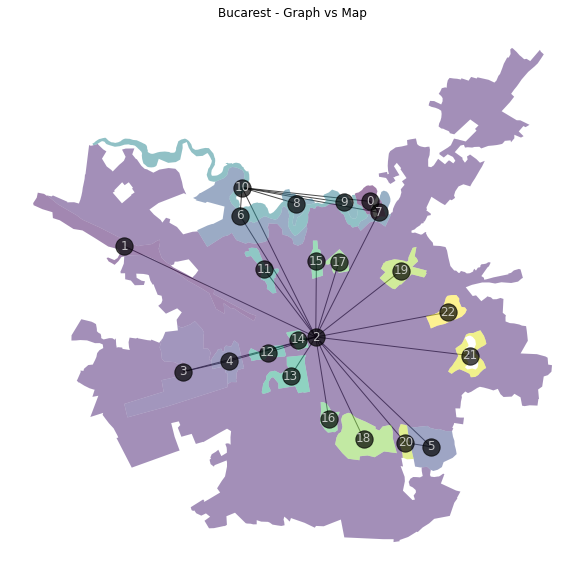

In [451]:
g, label = graph_class_dataset[6]
g_nx = dgl.to_networkx(g, node_attrs=g.ndata.keys(), edge_attrs=g.edata.keys()).to_undirected()
pos = nx.get_node_attributes(g_nx,'pos')
for key in pos:
    pos[key] = tuple(pos[key].tolist())

gdf = gpd.read_file("data/graph-class/data.gpkg", layer=label)

f, ax = plt.subplots(figsize=(20,10))
plt.title(f"{label} - Graph vs Map")
nx.draw(g_nx, pos=pos,  with_labels=True, ax=ax, alpha = 0.7, node_color=[(0,0,0,0.5)], font_color="white")
gdf.plot("Node_ID", alpha=0.5, ax=ax)
plt.show()

In [ ]:
## graphviz
# path = './a.out.png'
#
# ag = nx.nx_agraph.to_agraph(g_nx)
# ag.layout()
# ag.draw(path)
#
# img = mpimg.imread(path)
# plt.figure(figsize=(10,5))
# plt.imshow(img)
# plt.title(label)
# plt.show()
#
# os.remove(path)

In [ ]:
# autres exportations
# nx.write_graphml(g_nx, "test.graphml") # peut être utilisé avec cytoscape
# nx.drawing.nx_agraph.write_dot(g_nx, "test.dot") # dot file

# Classification de noeud

## Construction du jeu de données

## Construction du graphe

In [ ]:
# class NodeClassificationDataset(DGLDataset):
#     def __init__(self):
#         super().__init__(name='karate_club')
#
#     def process(self):
#         # nodes_data = gpd.read_file("data/zone-11-preprocessed.gpkg")
#         # neighborhood = pd.read_csv("data/zone-11-neighborhood.csv")
#
#         src_nodes = neighborhood.src
#         dest_nodes = neighborhood.dest
#         num_nodes = nodes_data.shape[0]
#
#         self.graph = dgl.graph((src_nodes, dest_nodes), num_nodes=num_nodes)
#
#         self.graph.ndata['label'] = torch.from_numpy(nodes_data.OBJECTID.to_numpy())
#         self.graph.ndata['area'] = torch.from_numpy(nodes_data.Area_Ha.to_numpy())
#         self.graph.ndata['code'] = torch.from_numpy(nodes_data.Code_18.to_numpy())
#         self.graph.edata['total_border'] = torch.from_numpy(neighborhood.total_border.to_numpy())
#         self.graph.edata['greatest_border'] = torch.from_numpy(neighborhood.greatest_border.to_numpy())
#         self.graph.edata['nb_border'] = torch.from_numpy(neighborhood.nb_border.to_numpy())
#
#         # masks indicating whether a node belongs to training, validation, and test set
#         n_train = int(num_nodes * 0.6)
#         n_val = int(num_nodes * 0.2)
#         train_mask = torch.zeros(num_nodes, dtype=torch.bool)
#         val_mask = torch.zeros(num_nodes, dtype=torch.bool)
#         test_mask = torch.zeros(num_nodes, dtype=torch.bool)
#         train_mask[:n_train] = True
#         val_mask[n_train:n_train + n_val] = True
#         test_mask[n_train + n_val:] = True
#         self.graph.ndata['train_mask'] = train_mask
#         self.graph.ndata['val_mask'] = val_mask
#         self.graph.ndata['test_mask'] = test_mask
#
#     def __getitem__(self, i):
#         return self.graph
#
#     def __len__(self):
#         return 1

In [ ]:
# node_classification_dataset = NodeClassificationDataset()

In [ ]:
# g = node_classification_dataset[0]
# plt.figure(figsize=(20,10))
# g_nx = dgl.to_networkx(g, node_attrs=g.ndata.keys(), edge_attrs=g.edata.keys()).to_undirected()
# nx.draw(g_nx, with_labels=True)